## Tree Based Models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.tree import _tree
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

def plotDecisionBoundary(classifier, X, y, title = None, cmap = "rainbow"):
    plt.figure(figsize=(12,8))
    ax = plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c = y, s = 30, cmap = cmap,
               clim = (y.min(), y.max()), zorder = 3)
    ax.axis("tight")
    ax.axis("off")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    xx, yy = np.meshgrid(np.linspace(*xlim, num = 200),
                         np.linspace(*ylim, num = 200))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha = 0.3,
                           levels = np.arange(n_classes + 1) - 0.5,
                           cmap = cmap, zorder = 1)
    if title:
        plt.title(title)
    ax.set(xlim = xlim, ylim = ylim)

# Requires Graphviz, you may not have it so ignore if this is the case
def treeToPicture(tree, target_names, feature_names=None):
    export_graphviz(tree, out_file = "tree.dot", 
                    class_names = target_names,
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    call(["dot", "-Tpng", "tree.dot", "-o", "tree.png", "-Gdpi = 600"])

    # Display in jupyter notebook
    display(Image(filename = "tree.png"))

def treeToCode(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else: # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

## Decision Trees

`scikit-learn` decision tree [user guide](https://scikit-learn.org/stable/modules/tree.html)

`DecisionTreeClassifier` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

### Parameters:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from inspect import signature

params = signature(DecisionTreeClassifier)
param_list = str(params).split(', ')[1:]

for param in param_list:
    print(param)

Let's create synthetic data since it is easy to visualize

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples = 300, centers = 4,
                  random_state = 0, cluster_std = 1.0)
plt.scatter(X[:, 0], X[:, 1], c = y, s = 50, cmap = "rainbow")
plt.show()

Let's see the decision boundaries

In [ ]:
import ipywidgets as widgets

from ipywidgets import interact, interactive
def f(x):
    if x == 0:
        dt = DecisionTreeClassifier(criterion = "gini", max_depth = None)
    else:
        dt = DecisionTreeClassifier(criterion = "gini", max_depth = x)
    dt.fit(X, y)
    plotDecisionBoundary(dt, X, y, "Decision Tree")

In [ ]:
interactive(f, x=(0,12))

In [ ]:
def f2(x):
    dt = DecisionTreeClassifier(criterion = "gini", max_depth = 8, min_samples_leaf=x)
    dt.fit(X, y)
    plotDecisionBoundary(dt, X,  y, "Decision Tree")
    
interactive(f2, x=(1,9))

In [ ]:
def f3(x):
    dt = DecisionTreeClassifier(criterion = "gini", max_depth = 8, min_samples_split=x)
    dt.fit(X, y)
    plotDecisionBoundary(dt, X,  y, "Decision Tree")
    
interactive(f3, x=(2,11))

It is also easy to get the rule set of the decision trees:

In [ ]:
dt = DecisionTreeClassifier(criterion = "gini", max_depth = 3)
dt.fit(X,y)
treeToCode(dt, ["X[0]", "X[1]"])

We can visualize the trees as well.

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,8))
plot_tree(dt)
plt.show()

In [ ]:
# A bit nicer (comment out if it doesn't work)
treeToPicture(dt, ["0", "1", "2", "3"])

Decision trees also calculate feature importances

In [ ]:
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature: %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

We can save and load the tree with pickle functionality.

In [ ]:
import pickle

pickle.dump(dt, open("decisiontree.p", "wb"))

In [ ]:
newDt = pickle.load(open("decisiontree.p", "rb"))
print(newDt)
treeToCode(newDt, ["X[0]", "X[1]"])

For details on pruning see [this](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html) and [this](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning).

In [ ]:
dt = DecisionTreeClassifier(criterion = "gini", max_depth = 10)
dt.fit(X, y)
ypred = dt.predict(X)

treeToPicture(dt, ["0", "1", "2", "3"])

In [ ]:
plotDecisionBoundary(dt, X, y, "Decision Tree")

In [ ]:
# Pruned version
dt = DecisionTreeClassifier(criterion = "gini", max_depth = 10, ccp_alpha = 0.05)
dt.fit(X, y)
treeToPicture(dt, ["0", "1", "2", "3"])

In [ ]:
plotDecisionBoundary(dt, X,  y, "Decision Tree")

## Tree Ensembles

The disadvantages of Decision Tree can be overcome with ensembling. Tree ensembles are among the most successful models in practice. Two tree ensemble ideas:

* Bagging: Random Forests
* Boosting: Gradient Boosted Trees

### Random Forests

We have seen random forests before so let's go over them again

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from inspect import signature

print(signature(RandomForestClassifier))

In [ ]:
from ipywidgets import IntSlider


def f_rf(ne, md, msl):
    if md == 0:
        rf = RandomForestClassifier(n_estimators = ne, 
                                    criterion = "gini",
                                    max_depth = None,
                                    min_samples_leaf = msl)
    else:
        rf = RandomForestClassifier(n_estimators = ne, 
                                    criterion = "gini",
                                    max_depth = md,
                                    min_samples_leaf = msl)
    rf.fit(X, y)
    plotDecisionBoundary(rf, X,  y, "Random Forest")

In [ ]:
interactive(f_rf,ne=IntSlider(min=5, max=200, step=5, value=50),md=(0,10),msl=(1,11))

In [ ]:
rf = RandomForestClassifier(n_estimators = 10, 
                            criterion = "gini",
                            max_depth = 2,
                            min_samples_leaf = 5)
rf.fit(X, y)
plotDecisionBoundary(rf, X,  y, "Random Forest")

In [ ]:
print(rf.estimators_[0])

In [ ]:
treeToPicture(rf.estimators_[2], ["0", "1", "2", "3"])

As we have seen multiple times, random forests calculate feature importances. We can even calculate the variance on these importances by utilizing the feature importances of the individual trees. We have done this before so only showing recapping the importances

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature Ranking:")
for f in range(X.shape[1]):
    print("%d. feature: %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

**Some Points:**
* A suitable choice if the data is noisy
* Main parameter to tune is the number of trees (`n_estimators`)
* Can be a bit more aggressive in picking the maximum depth, compared to decision trees
* Random Forests have low but non-zero risk of over-fitting. In this case, `min_samples_leaf` parameter can be tuned or do pruning if depth allows it
* Calibration is strongly recommended if probabilities are to be used (classification). Look for "Probability Calibration" and scikit-learn

### Gradient Boosted Trees

As we have seen it before, `scikit-learn` has its own gradient boosted tree implementation

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
print(signature(GradientBoostingClassifier))
GradientBoostingClassifier()

In [ ]:
def f_gb(ne, md, msl, lr):
    if md == 0:
        gb = GradientBoostingClassifier(n_estimators = ne, 
                                    max_depth = None,
                                    min_samples_leaf = msl,
                                    learning_rate=lr/200)
    else:
        gb = GradientBoostingClassifier(n_estimators = ne, 
                                    max_depth = md,
                                    min_samples_leaf = msl,
                                    learning_rate=lr/200)
    gb.fit(X, y)
    plotDecisionBoundary(gb, X, y, "Gradient Boosted Trees")

In [ ]:
interactive(f_gb,ne=IntSlider(min=2, max=100, step=2, value=50),md=(0,10),msl=(1,11),lr=(1,50))

We will see more about these with the upcoming libraries.

### XGBoost

[XGBoost](https://xgboost.readthedocs.io/en/stable/) library provides a regularizing gradient boosting framework. It's "designed to be highly efficient, flexible and portable." It is used for many industrial level machine learning problems, winning multiple machine learning competitions. It can work on single machines and distributed computing environments alike. We are going to concentrate on single machine usage.

XGBoost works with numpy arrays and pandas data frames. XGBoost estimators implement scikit-learn APIs. In addition, it provides its own data structures and its own API. We will stick with numpy, pandas and scikit-learns APIs, as much as possible, since they are more familiar.

A useful repository of XGBoost resources can be found [here](https://github.com/dmlc/xgboost/tree/master/demo)

In [ ]:
import xgboost as xgb

from xgboost import XGBClassifier

# Most of the Parameters, 
# for all of them: https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster
gbtc = XGBClassifier(
    max_depth = 3, 
    learning_rate = 0.1, # aka eta
    n_estimators = 100, # equivalent to number of boosting rounds
    verbosity = 1,
    objective = "binary:logistic", # should be selected based on the ml problem
    booster = "gbtree", # which algorithm to use
    n_jobs = 1,
    gamma = 0, # minimum loss required to split, aka min_loss_split
    min_child_weight = 1, # minimum sum of instance weight (hessian) needed to continue splitting
    max_delta_step = 0, # maximum delta step allowed for each leaf output, may be needed for severe imbalance
    subsample = 1, # amount of data to fit at each iteration, helps with overfitting
    sampling_method = 'uniform', # method to use for above sampling
    colsample_bytree = 1,  # related to feature (column) sampling
    colsample_bylevel = 1,
    colsample_bynode = 1,
    reg_alpha = 0, #l1 loss parameter
    reg_lambda = 1, #l2 loss parameter
    tree_method = 'auto', # which tree learning algorithm to use
    scale_pos_weight = 1, # similar to class weights in sklearn, usually the ratio of negative instances to positive 
    base_score = 0.5, # initial score of all instances (also called the global bias)
    random_state = 0, 
    missing = None
)

A useful parameter `interaction_constraints` which let's you add domain knowledge by specifying which features interact with each other. We are going to skip it but I recommend you go over this.

In [ ]:
# Let's start with our data

def f_gbxgb(ne, md, gm, lr, l2reg, mcw):
    gbtc = XGBClassifier(max_depth = md,
                        learning_rate = lr/50,
                        n_estimators = ne,
                        gamma = gm/50,
                        reg_lambda = l2reg/50,
                        min_child_weight = mcw/20,
                        objective = "multi:softprob") # multi-class classification
    gbtc.fit(X, y)
    plotDecisionBoundary(gbtc, X,  y, "XGBoost")
    
interactive(f_gbxgb,ne=IntSlider(min=2, max=50, step=1, value=10),md=(1,20),gm=(0,200),lr=(1,50),l2reg=(0,100), mcw =(0,40))

In [ ]:
# Another alternative
param = {"max_depth": 3,
         "eta": 0.3,
         "objective": "multi:softprob",
         "num_class": 4,
         "verbosity": 1}  

dtrain = xgb.DMatrix(X, label=y)

gbtc = xgb.train(param, dtrain, num_boost_round = 20)

gbtc.predict(dtrain)

# gbtc.predict(X) will not work now!

In [ ]:
gbtc

In [ ]:
dtrain

XGBoost has its own feature importances

In [ ]:
from xgboost import plot_importance

gbtc = XGBClassifier(max_depth = 3,
                    learning_rate = 0.3,
                    n_estimators = 20,
                    gamma = 0.05,
                    objective = "multi:softprob") # multi-class classification
gbtc.fit(X, y)

print(gbtc.feature_importances_) # based on gain

plot_importance(gbtc)
plt.show()

In [ ]:
plot_importance(gbtc, importance_type='gain')
plot_importance(gbtc, importance_type='cover')

In [ ]:
# Also support probability output
gbtc.predict_proba(X)

In [ ]:
gbtc.predict(X)

**Comments:**
* Gradient Boosted Trees in general perform better than Random Forests. However, overfitting is a risk. As a result, more care needs to be taken into account for hyperparameter tuning.
* Ideally, depth of each tree is limited to avoid over fitting. Number of estiomators, gamma and eta parameters also play an important role.
* The number of boosting rounds (or equivalently number of estimators) are also important in overfitting
* If the feature interactions are important (i.e. depth and/or number of rounds are required), other parameters need to be tuned.
* Similar to RFs, calibration may be needed if probability values are important

XGBoost library also supports random forests

In [ ]:
from xgboost import XGBRFClassifier

xgb_rf = XGBRFClassifier(max_depth = 3,
                         n_estimators = 100)

xgb_rf.fit(X,y)

In [ ]:
plotDecisionBoundary(xgb_rf, X, y, "XGBoost RF")

### LightGBM

As you add more depth to decision trees, they actually grow **wider**, exponentially so! This is called level-wise growth. Some parameters and pruning help with this. 

LightGBM takes a more Leaf-wise approach; it grows the trees deeper if a branch is promising. One advantage of this is training speed. Another advantage is it captures more feature interactions. LightGBM also bins the continuous valued features which makes it easier to decide on the splitting points, resulting in further speed-ups. Side note, XGBoost also added this feature (need to pick the tree algorithm accordingly)

In [ ]:
import lightgbm as lgbm
from lightgbm import LGBMClassifier

params = signature(LGBMClassifier)
param_list = str(params).split(', ')[:]

for param in param_list:
    print(param)

In [ ]:
LGBMClassifier()

In [ ]:
# Let's start with our data
def f_lgbm(ne, md, lr, nl, mcs):
    gbtc = LGBMClassifier(max_depth = md,
                          learning_rate = lr/50,
                          n_estimators = ne,
                          num_leaves  = nl,
                          min_child_samples = mcs,
                          objective = "multiclass") # multi-class classification
    gbtc.fit(X, y)
    plotDecisionBoundary(gbtc, X,  y, "LGBM")

interactive(f_lgbm,ne=IntSlider(min=2, max=50, step=1, value=10),md=(0,30),lr=(1,50), nl = (2,50), mcs =(1,50))


In [ ]:
lgbm_cl = LGBMClassifier(max_depth = 10,
                    learning_rate = 0.3,
                    n_estimators = 20,
                    num_leaves  = 20,
                    objective = "multi:softprob") # multi-class classification
lgbm_cl.fit(X, y)
print(lgbm_cl.feature_importances_)
lgbm.plot_importance(lgbm_cl)

In [ ]:
lgbm.plot_importance(lgbm_cl, importance_type='gain')

In [ ]:
1180/(1180+470)

**Example**

Let's work on a slightly more complicated example we have used during advanced pipelining

In [ ]:
from sklearn.datasets import fetch_openml

# You need an internet connection
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

# If the above doesn't work (loads it but with different column names)
#from catboost.datasets import titanic
#X, y = titanic()

display(X)

In [ ]:
y

Let's remember the features:
* sibsp: Number of Siblings/Spouses Aboard
* parch: Number of Parents/Children Aboard
* survival - Survival (0 = No; 1 = Yes)
* pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* ticket - Ticket Number
* fare - Passenger Fare
* cabin - Cabin
* embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
* boat - Lifeboat (if survived)
* body - Body number (if did not survive and body was recovered)

In [ ]:
X.info()

In [ ]:
X.describe()

In [ ]:
X.describe(include=object)

In [ ]:
X.describe(include='category')

In [ ]:
y.value_counts()

In [ ]:
X = X.drop(['name','ticket','boat','home.dest','cabin','body'],axis=1)

In [ ]:
ez_df = X.copy()
ez_df['survived'] = y

baseline_accuracy = ((ez_df[ez_df['sex']=='female']['survived']=='1').sum()+(ez_df[ez_df['sex']=='male']['survived']=='0').sum())/1309
print(baseline_accuracy)

In [ ]:
# Needed since LabelEncoder does not play nicely with pipelines
from sklearn.preprocessing import LabelEncoder

class PipelineLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        X = np.empty(y.shape)
        df = False
        if type(y) == pd.DataFrame:
            df = True
        for i in range(y.shape[1]):
            if df:
                X[:,i] = super().fit_transform(y.iloc[:,i])
            else:
                X[:,i] = super().fit_transform(y[:,i])
        return X

    def transform(self, y, *args, **kwargs):
        X = np.empty(y.shape)
        df = False
        if type(y) == pd.DataFrame:
            df = True
        for i in range(y.shape[1]):
            if df:
                X[:,i] = super().transform(y.iloc[:,i])
            else:
                X[:,i] = super().transform(y[:,i])
        return X

In [ ]:
from sklearn.preprocessing import LabelEncoder,  OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

"""
**Lvl 1:**
* sex: to binary, labelencoder is fine
* embarked: missing value as the most frequent port (since we do not have many missing values)
* embarked: to-one-hot
"""

genderLenc = ('GenderLabelEncoder', PipelineLabelEncoder(), ['sex'])
#genderLenc = ('GenderLabelEncoder', LabelEncoder(), ['sex']) uncomment to see

embarkedInit = ('EmbarkedInit', 
                Pipeline([('EmbarkedImpute', SimpleImputer(strategy='most_frequent')),
                          ('EmbarkedOneHot',OneHotEncoder(handle_unknown='ignore'))]),  ['embarked'])

# passthrough changes the order. Furthermore we lose the pandas dataframe. After this, 
# we will need to keep track of the indices. This is a trade-off of scikit-learn where they 
# value numpy array compatibility over pandas dataframe compatibility but work is being done

# order before: pclass, sex, age, sibsp, parch, fare, embarked
# order after the below: sex, embarked x 3 (1 hot), pclass, age, sibsp, parch, fare
firstLevelCT = ColumnTransformer([genderLenc, embarkedInit], remainder='passthrough')

"""
**Lvl 2:**
* overall iterative imputation
"""

# order after the below: sex, embarked x 3 (1hot), pclass, age, sibsp, parch, fare, i.e., no change
#allImputer = ('AllImpute', 
#               IterativeImputer(estimator=RandomForestRegressor(n_estimators=50), max_iter=10, tol=0.01), 
#               np.arange(9))
#secondLevelCT = ColumnTransformer([allImputer])
secondLevel = Pipeline([('AllImpute',IterativeImputer(estimator=RandomForestRegressor(n_estimators=50), 
                                                      max_iter=10, 
                                                      tol=0.01))])

pipe = Pipeline ([('first', firstLevelCT), ('second', secondLevel)]) 

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, stratify=y, random_state=2101)
ytrain = ytrain.astype('int')
ytest = ytest.astype('int')

In [ ]:
Xtrain_pipe = pipe.fit_transform(Xtrain)
Xtest_pipe = pipe.transform(Xtest)

In [ ]:
from sklearn.metrics import accuracy_score

def test(clf, Xtrain, Xtest, ytrain, ytest, name = None, refit = True):
    if refit:
        clf.fit(Xtrain, ytrain)
    ytrainPred = clf.predict(Xtrain)
    ytestPred = clf.predict(Xtest)
    if name:
        print(name)
    else:
        print(clf.steps[1][0])
    print('Train:',accuracy_score(ytrain,ytrainPred))
    print('Test:',accuracy_score(ytest,ytestPred))

In [ ]:
rf = RandomForestClassifier()
xgb_cl = XGBClassifier(use_label_encoder = False, eval_metric='logloss')
lgbm_cl = LGBMClassifier()

test(rf, Xtrain_pipe, Xtest_pipe, ytrain, ytest, name = 'RF', refit = True)
test(xgb_cl, Xtrain_pipe, Xtest_pipe, ytrain, ytest, name = 'XGB', refit = True)
test(lgbm_cl, Xtrain_pipe, Xtest_pipe, ytrain, ytest, name = 'LGBM', refit = True)

We will modify the codes below together!

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

In [ ]:
# Random Forest
cv = StratifiedKFold(n_splits=5, shuffle=True)

param_grid = {'n_estimators':[50,100,200,300],
              'max_depth':[3,5,8,12,None]}

gsrf = GridSearchCV(rf, param_grid, cv = cv)
test(gsrf, Xtrain_pipe, Xtest_pipe, ytrain, ytest,'rf with grid')
print(gsrf.best_estimator_.n_estimators, gsrf.best_estimator_.max_depth)

In [ ]:
xgb_cl

In [ ]:
param_grid = {'n_estimators':[10,25,50],
              'max_depth':[2,3,6],
              'learning_rate': np.linspace(0.05,0.3,50),
              'scale_pos_weight': np.linspace(1,2,6)}

gsxgb = RandomizedSearchCV(xgb_cl, param_grid, cv = cv,n_iter=100)
test(gsxgb, Xtrain_pipe, Xtest_pipe, ytrain, ytest,'xgb with grid')
print(gsxgb.best_estimator_.n_estimators, 
      gsxgb.best_estimator_.max_depth, 
      gsxgb.best_estimator_.learning_rate, 
      gsxgb.best_estimator_.scale_pos_weight)

In [ ]:
print(gsxgb.best_estimator_.n_estimators, 
      gsxgb.best_estimator_.max_depth, 
      gsxgb.best_estimator_.learning_rate, 
      gsxgb.best_estimator_.scale_pos_weight)

In [ ]:
param_grid = {'n_estimators':[25,50,100,200],
              'max_depth':[3,5,8,12],
              'num_leaves':np.arange(20,51),
              'learning_rate': np.linspace(0.05,0.3,50),
              'min_child_samples':np.arange(0,31),
              'class_weight':['balanced',None]}

gslgbm = RandomizedSearchCV(lgbm_cl, param_grid, cv = cv,n_iter=100)
test(gslgbm, Xtrain_pipe, Xtest_pipe, ytrain, ytest,'lgbm with grid')
print(gslgbm.best_estimator_.n_estimators, 
      gslgbm.best_estimator_.max_depth, 
      gslgbm.best_estimator_.learning_rate, 
      gslgbm.best_estimator_.num_leaves,
      gslgbm.best_estimator_.min_child_samples,
      gslgbm.best_estimator_.class_weight)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=3)
test(dt,Xtrain_pipe, Xtest_pipe, ytrain, ytest,'dt')

**Categorical Features Revisited**

Let's use the built-in functionality to handle the categorical features.

In [ ]:
# starting fresh
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

In [ ]:
display(X)

In [ ]:
X = X.drop(['name','ticket','boat','body'],axis=1)
print(X.columns)

In [ ]:
X['cabin'].value_counts()

In [ ]:
X['home.dest'].value_counts()

Let's try to add cabin and home.dest aswell. If we add them as is, the cardinality of these categories would decrease our performance immensely!

In [ ]:
def homeDestParser(x):
    if x is None:
        return None #"NaN"
    return x.split(', ')[-1]    

In [ ]:
X['home.dest.parsed.tmp'] = X['home.dest'].apply(homeDestParser)
tmp = X['home.dest.parsed.tmp'].value_counts()
tmp2 = tmp.drop((tmp[tmp<5]).index)
X['home.dest.parsed']=X['home.dest.parsed.tmp'].apply(lambda x : x if (x in tmp2) else 'Other')
X=X.drop(['home.dest','home.dest.parsed.tmp'],axis=1)

In [ ]:
tmp2

In [ ]:
display(X)

In [ ]:
def cabinParserAlpha(x):
    if x is None:
        return None
    return x[0]

def cabinParserNum(x):
    if x is None:
        return None
    elif x[1:3].isnumeric():
        return int(x[1:3]) #//10
    elif len(x) == 1:
        return 0
    elif x[1].isnumeric():
        return x#%10
    else:
        return cabinParserNum(x[2:])

In [ ]:
X['cabin.parsed.A'] = X['cabin'].apply(cabinParserAlpha)
X['cabin.parsed.N'] = X['cabin'].apply(cabinParserNum)
X = X.drop('cabin', axis=1)

In [ ]:
categorical_features = ['sex', 'embarked', 'cabin.parsed.A','home.dest.parsed']
other_features = list(set(X.columns) - set(categorical_features))
print(other_features)

In [ ]:
for i in categorical_features:
    print(len(X[i].value_counts()))

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, stratify=y, random_state=2101)
ytrain = ytrain.astype('int')
ytest = ytest.astype('int')

In [ ]:
class PipelineLabelEncoderMulti(LabelEncoder):
    
    def __init__(self):
        self.label_encoder_list = []

    def fit(self, y, *args, **kwargs):
        self.label_encoder_list = []
        X = np.empty(y.shape)
        df = False
        if type(y) == pd.DataFrame:
            df = True
        for i in range(y.shape[1]):
            le = LabelEncoder()
            if df:
                le.fit(y.iloc[:,i])
            else:
                le.fit(y[:,i])
            self.label_encoder_list.append(le)
        return X
        
    def fit_transform(self, y, *args, **kwargs):
        self.label_encoder_list = []
        X = np.empty(y.shape)
        df = False
        if type(y) == pd.DataFrame:
            df = True
        for i in range(y.shape[1]):
            le = LabelEncoder()
            if df:
                X[:,i] = le.fit_transform(y.iloc[:,i]).astype('int')
            else:
                X[:,i] = le.fit_transform(y[:,i]).astype('int')
            self.label_encoder_list.append(le)
        return X

    def transform(self, y, *args, **kwargs):
        X = np.empty(y.shape)
        df = False
        if type(y) == pd.DataFrame:
            df = True
        for i in range(y.shape[1]):
            if df:
                tmp = y.iloc[:,i]
            else:
                tmp = y[:,i]
            ignored = set(tmp) - set(self.label_encoder_list[i].classes_)
            if(len(ignored) > 0):
                for ign in ignored:
                    tmp[tmp == ign] = None# "NaN"
            X[:,i] = self.label_encoder_list[i].transform(tmp).astype('int')
        return X

In [ ]:
# Need to have integer encoding! Label encoder anyone?
ct1 = ColumnTransformer([('pel',PipelineLabelEncoderMulti(),categorical_features)], 
                       remainder='passthrough')
ct2 = ColumnTransformer([('si',SimpleImputer(strategy="constant", fill_value=-1),list(range(len(categorical_features))))], 
                       remainder='passthrough')

pp = Pipeline([('ct1',ct1),('ct2',ct2)])

In [ ]:
Xtrain_label_encoded = pp.fit_transform(Xtrain)
Xtest_label_encoded  = pp.transform(Xtest)

In [ ]:
Xtrain_label_encoded = pd.DataFrame(Xtrain_label_encoded)
Xtest_label_encoded  = pd.DataFrame(Xtest_label_encoded)

In [ ]:
for i in range(len(categorical_features)):
    Xtrain_label_encoded.iloc[:,i] = Xtrain_label_encoded.iloc[:,i].astype('category')
    Xtest_label_encoded.iloc[:,i]  = Xtest_label_encoded.iloc[:,i].astype('category')

In [ ]:
Xtrain_label_encoded.dtypes

In [ ]:
lgbm2 = LGBMClassifier()
lgbm2.fit(Xtrain_label_encoded, 
          ytrain, 
          categorical_feature=list(Xtrain_label_encoded.index[:len(categorical_features)]))

In [ ]:
test(lgbm2,Xtrain_label_encoded, Xtest_label_encoded, ytrain, ytest,'lgbm_cat',False)

In [ ]:
param_grid = {'n_estimators':[25,50,100,200],
              'max_depth':[3,5,8,12],
              'num_leaves':np.arange(20,51),
              'learning_rate': np.linspace(0.05,0.3,50),
              'min_child_samples':np.arange(0,31),
              'class_weight':['balanced',None]}

gslgbm = RandomizedSearchCV(lgbm2, param_grid, cv = cv,n_iter=50)
gslgbm.fit(Xtrain_label_encoded, ytrain, 
           categorical_feature=list(Xtrain_label_encoded.index[:len(categorical_features)]))


In [ ]:
test(gslgbm, Xtrain_label_encoded, Xtest_label_encoded, ytrain, ytest,'lgbm with grid', False)
print(gslgbm.best_estimator_.n_estimators, 
      gslgbm.best_estimator_.max_depth, 
      gslgbm.best_estimator_.learning_rate, 
      gslgbm.best_estimator_.num_leaves,
      gslgbm.best_estimator_.min_child_samples,
      gslgbm.best_estimator_.class_weight)

In [ ]:
xgb_cl2 = xgb.XGBClassifier(tree_method="gpu_hist", 
                            enable_categorical=True, 
                            use_label_encoder=False, 
                            eval_metric='logloss')

test(xgb_cl2, Xtrain_label_encoded, Xtest_label_encoded, ytrain, ytest,'xgb cat')

In [ ]:
param_grid = {'n_estimators':[10,25,50],
              'max_depth':[2,3,6],
              'learning_rate': np.linspace(0.05,0.3,50),
              'scale_pos_weight': np.linspace(1,2,6)}

gsxgb = RandomizedSearchCV(xgb_cl2, param_grid, cv = cv,n_iter=100)
test(gsxgb, Xtrain_pipe, Xtest_pipe, ytrain, ytest,'xgb with grid')
print(gsxgb.best_estimator_.n_estimators, 
      gsxgb.best_estimator_.max_depth, 
      gsxgb.best_estimator_.learning_rate, 
      gsxgb.best_estimator_.scale_pos_weight)

### CatBoost

There are many categorical encoding approaches in the literature. Even though one-hot encoding is one of the most used one, it increases the sparsity of the data immensely especially if the number of categories (aka cardinality) is large. [Catboost](https://catboost.ai/) has built-in functionality to use other types on encoding as well.

In [ ]:
import catboost
from catboost import CatBoostClassifier

params = signature(CatBoostClassifier)
param_list = str(params).split(', ')

for param in param_list:
    print(param)

In [ ]:
Xblobs, yblobs = make_blobs(n_samples = 300, centers = 4,
                            random_state = 0, cluster_std = 1.0)

In [ ]:
gbtc = CatBoostClassifier(iterations = 10, # number of iterations == number of trees
                              learning_rate=0.1,
                              depth = 3,
                              loss_function='MultiClass',
                              logging_level = "Silent")  
gbtc.fit(Xblobs, yblobs)

In [ ]:
def f_cb(ne, md, lr):
    gbtc = CatBoostClassifier(iterations = ne, # number of iterations == number of trees
                              learning_rate=lr/50,
                              depth = md,
                              loss_function='MultiClass',
                              logging_level = "Silent")  
    gbtc.fit(Xblobs, yblobs)
    plotDecisionBoundary(gbtc, Xblobs,  yblobs, "Catboost")

interactive(f_cb,ne=IntSlider(min=2, max=50, step=1, value=10),md=(0,12),lr=(1,50))


In [ ]:
Xtrain_cb = Xtrain.copy()
Xtest_cb  = Xtest.copy()
for cat in categorical_features:
    Xtrain_cb[cat] = Xtrain_cb[cat].astype(object)
    Xtest_cb[cat] = Xtest_cb[cat].astype(object)
Xtrain_cb.fillna(-999, inplace = True)
Xtest_cb.fillna(-999, inplace = True)

In [ ]:
categorical_feature_indices_cb = np.where(np.in1d(Xtrain_cb.columns,categorical_features))[0].astype('int')
cb_clf = CatBoostClassifier(iterations= 100, logging_level = "Silent")

cb_clf.fit(Xtrain_cb, ytrain, cat_features = categorical_feature_indices_cb)
test(cb_clf,Xtrain_cb,Xtest_cb,ytrain,ytest,'catboost',False)

In [ ]:
from sklearn import utils
cw=utils.class_weight.compute_class_weight('balanced', np.unique(ytrain.values), ytrain)
cw

In [ ]:
param_grid = {'iterations': [10,25,50,100], # number of iterations == number of trees
              'learning_rate':np.linspace(0.05,0.3,50),
              'depth':[2,3,6,10],
              'one_hot_max_size':[5,10,30], #this requires the knowledge of number of categories
              'class_weights': [[1,1],cw]
             } 
cb_clf = CatBoostClassifier(logging_level = "Silent", cat_features=categorical_feature_indices_cb)
rscb = RandomizedSearchCV(cb_clf, param_grid, cv = cv,n_iter=10)
rscb.fit(Xtrain_cb, ytrain)
test(rscb, Xtrain_cb, Xtest_cb, ytrain, ytest,'cb with grid',False)
print(rscb.best_estimator_.get_param('iterations'),
      rscb.best_estimator_.get_param('depth'),
      rscb.best_estimator_.get_param('learning_rate'),
      rscb.best_estimator_.get_param('one_hot_max_size'),
      rscb.best_estimator_.get_param('class_weights')
     )

In [ ]:
cb_clf = CatBoostClassifier(iterations= 100, logging_level = "Silent", cat_features=categorical_feature_indices_cb)

cb_clf.randomized_search(param_grid,
                  Xtrain_cb,
                  ytrain,
                  cv=3,
                  n_iter=10,
                  plot=True)
test(cb_clf, Xtrain_cb, Xtest_cb, ytrain, ytest,'cb with grid', False)
print(cb_clf.get_param('iterations'),
      cb_clf.get_param('depth'),
      cb_clf.get_param('learning_rate'),
      cb_clf.get_param('one_hot_max_size'),
      cb_clf.get_param('class_weights')
     )

A relatively old but useful cheatsheet:

(This is incomplete and we have discussed more details durig the lectures!)

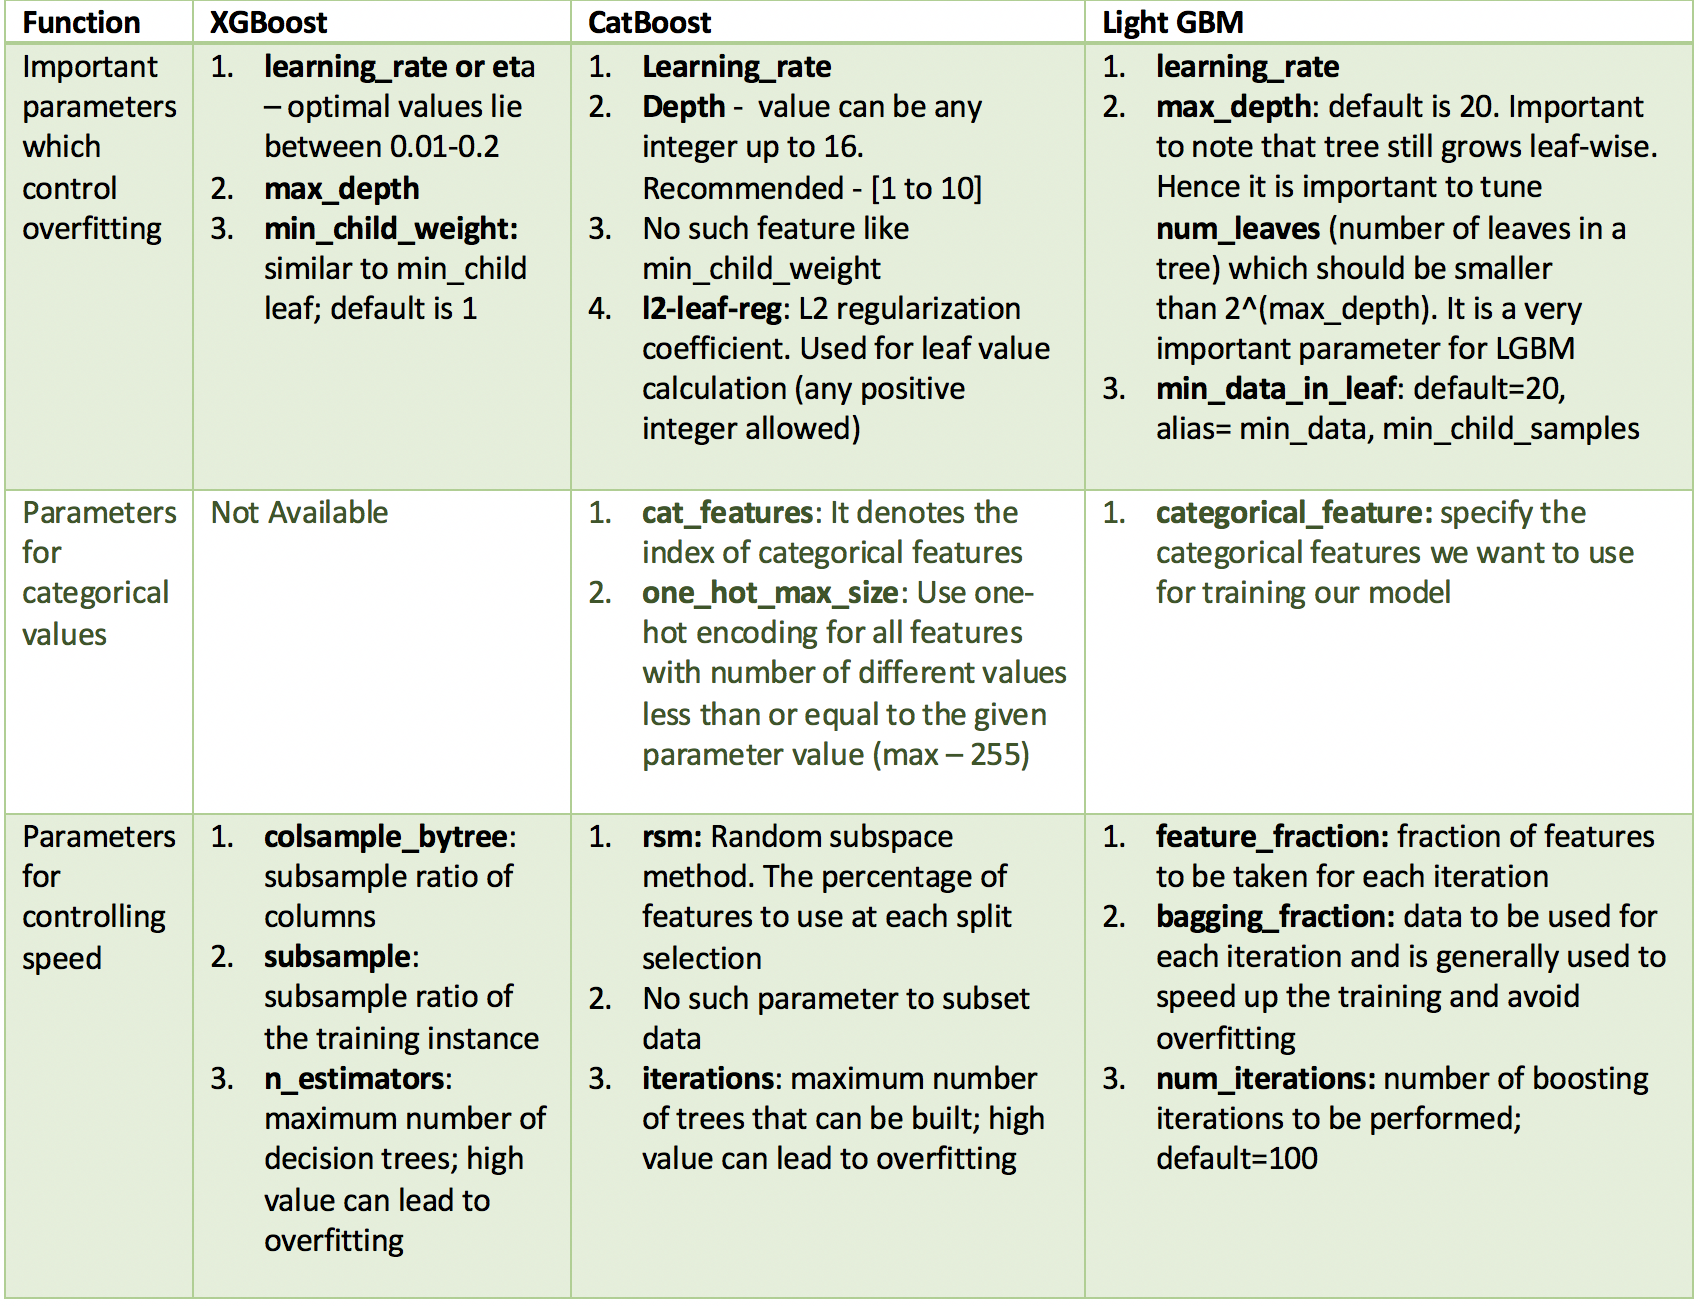